In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import boto3
from sagemaker import get_execution_role
role = get_execution_role()
bucket='machine-learning-uni'
data_key = 'week2/assignment/heart.disease.data.clean.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location)
df.info()
clean_df = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       282 non-null    int64  
 1   sex       282 non-null    int64  
 2   cp        282 non-null    int64  
 3   trestbps  282 non-null    int64  
 4   chol      282 non-null    int64  
 5   cigs      282 non-null    float64
 6   years     282 non-null    float64
 7   fbs       282 non-null    int64  
 8   famhist   282 non-null    int64  
 9   restecg   282 non-null    int64  
 10  thalach   282 non-null    int64  
 11  exang     282 non-null    int64  
 12  thal      282 non-null    int64  
 13  num       282 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 31.0 KB


<AxesSubplot:>

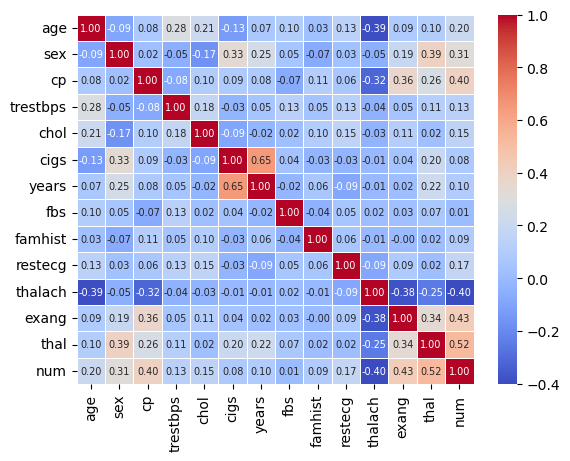

In [4]:
# Feature selection based on correlation matrix
df_clean = df.copy()
df_clean.loc[df_clean['num'] > 0, 'num'] = 1
sns.heatmap(df_clean.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 7}, linewidths=.5)

In [5]:
# Selected predictors with abs corr >= .15
target_col = 'num'
feature_cols = ['age', 'sex', 'cp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'thal'] # 
X = df_clean[feature_cols].values
y = df_clean[target_col].values

In [6]:
# Get training set of 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalized data to improve accurracy
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [7]:
# Model fit with k=1 as base line
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.77      0.82      0.79        28

    accuracy                           0.79        57
   macro avg       0.79      0.79      0.79        57
weighted avg       0.79      0.79      0.79        57



In [8]:
# reusable function to plot confusion matrix
def chart_cm(cf_matrix, ax=None):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

AxesSubplot(0.125,0.11;0.62x0.77)


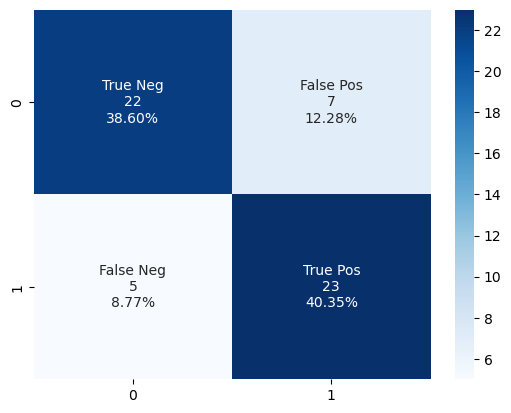

In [9]:
# k=1 confusion matrix
cf_matrix1 = confusion_matrix(y_test, y_pred)
print(chart_cm(cf_matrix1))

In [10]:
# Select best k parameter for the model
scores = []
best_score = [0, None, 0]
k_limit = 41 # 1..40
for k in range(1, k_limit):
    classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    score = accuracy_score(y_test, y_pred) # classifier.score(X_test, y_test)
    false_neg = cf_matrix[1][0]
    scores.append(score)
    if score > best_score[0]:
        if best_score[1] is None or best_score[1] < false_neg:
            best_score = [score, false_neg, k]
    # print(k, score, false_neg, cf_matrix[0][1])
print('Best Score: {0} False Neg: {1} k: {2}'.format(best_score[0], best_score[1], best_score[2]) )

Best Score: 0.8070175438596491 False Neg: 7 k: 5


40


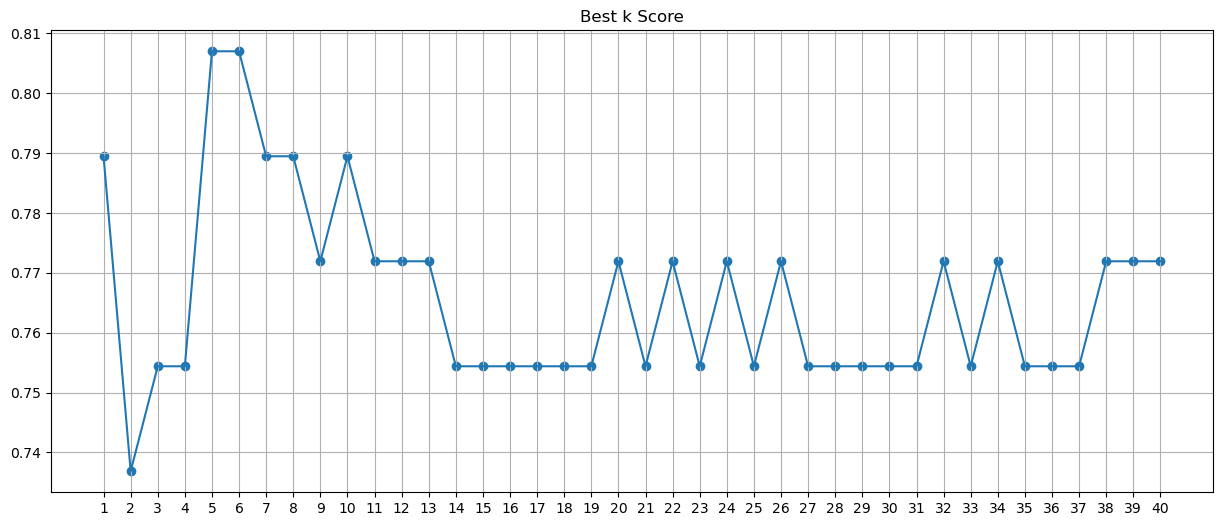

In [11]:
# Plot model scores selection
print(len(scores))
plt.figure(figsize=(15,6))
plt.plot(range(1, k_limit), scores)
plt.scatter(range(1, k_limit), scores)
plt.title('Best k Score')
plt.grid()
_ = plt.xticks(range(1, k_limit))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.84      0.75      0.79        28

    accuracy                           0.81        57
   macro avg       0.81      0.81      0.81        57
weighted avg       0.81      0.81      0.81        57



<AxesSubplot:title={'center':'k=1'}>

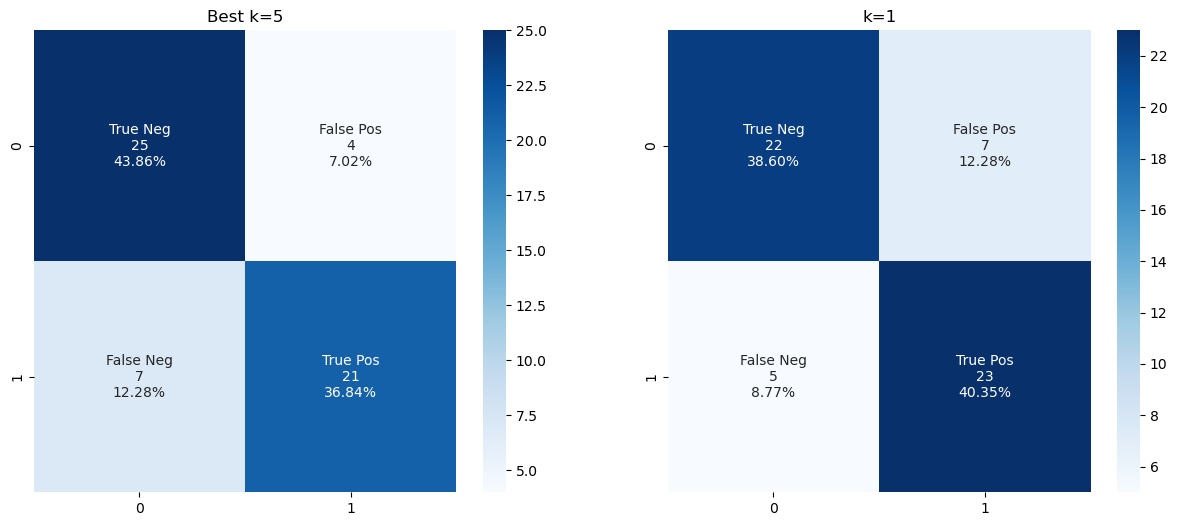

In [12]:
# Results of best model
k = best_score[2]
classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

# Compare best model against base line (k=1)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].set_title('Best k='+str(k))
axs[1].set_title('k=1')
chart_cm(cf_matrix, ax=axs[0])
chart_cm(cf_matrix1, ax=axs[1])

# Summary

- Feature selection was made based on correlation matrix, including predictors with abs corr >= .15 only
- The training set used is 20% data set
- Base line model fit was k=1
- The final k parameter was chosen based on best model of the k=1..40
- The selection criteria was the model with higher accuracy score, then lower False Negatives.
- The model accuracy score was improved by 16.05% after normalizing the predictor values

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
classifiers = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GaussianNB, SVC]
print('KNeighborsClassifier (best k={0}): {1:.2f} '.format(k, best_score[0]))
for c in classifiers:
    classifier_model = c()
    y_pred = classifier_model.fit(X_train, y_train).predict(X_test)
    print('{0}: {1:.2f} '.format(c.__name__, accuracy_score(y_test, y_pred)))



KNeighborsClassifier (best k=5): 0.81 
LogisticRegression: 0.74 
DecisionTreeClassifier: 0.77 
RandomForestClassifier: 0.72 
GaussianNB: 0.77 
SVC: 0.79 


In [17]:
import joblib
import tempfile
import sklearn

print(sklearn.__version__)
with tempfile.TemporaryFile() as tf:
    s3_client = boto3.client('s3')
    joblib.dump(classifier, tf)
    tf.seek(0)
    s3_client.put_object(Body=tf.read(), Bucket=bucket, Key='week2_solution.pkl')

1.0.1
